# Switches

In [1814]:
# Data loading
sw_data_leakage = True

# Missing values
sw_impute_latitude = True
sw_gps_height_model_imput = False
sw_use_new_installer_method = True
sw_use_new_funder_method = True

# Feature engineering
sw_population_bins = True
sw_region_target_encoding = True
sw_oversampling = False
sw_extraction_type_class_eng = True
sw_gps_height_reduce_card = True
sw_waterpoint_type_adjust = True
sw_pump_density = True

In [1815]:
def distribution_checker (data, xlabel):
  grouped = data.groupby([xlabel, 'status_group'])['id'].count().reset_index()
  pivot = grouped.pivot_table(index = xlabel, columns = 'status_group', fill_value = 0)
  mi=pivot.columns
  mi.tolist()
  ind = pd.Index([ str(e[1])  for e in mi.tolist()])
  pivot.columns = ind
  pivot['nr_pumps'] = pivot['functional'] +pivot['functional needs repair'] +pivot['non functional']
  pivot['all_pumps'] = pivot['nr_pumps'].sum()
  pivot['perc_total_pumps'] =((pivot['nr_pumps']/pivot['all_pumps'])*100).round(1)
  pivot['perc_functional'] = ((pivot['functional']/pivot['nr_pumps'])*100).round(1)
  pivot['perc_non_functional'] = ((pivot['non functional']/pivot['nr_pumps'])*100).round(1)
  pivot['perc_functional_needs_repair'] = ((pivot['functional needs repair']/pivot['nr_pumps'])*100).round(1)
  pivot = pivot.drop(['functional', 'functional needs repair', 'non functional', 'all_pumps'], axis=1)
  return(pivot)

# Data Preprocessing

Includes imputation and deletion of bad features.

### Import Dependencies

In [1816]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.preprocessing import LabelEncoder

pd.set_option('display.max_columns', None)

### Load Data

In [1817]:
train_base_df = pd.read_csv("project/data/train/features.csv", parse_dates = ['date_recorded' ],  na_values = [0, '0'])
labels = pd.read_csv("project/data/train/labels.csv")

test_df = pd.read_csv("project/data/test/test.csv", parse_dates = ['date_recorded' ],  na_values = [0, '0'])

# Merge features and labels files
train_df = pd.merge(labels, train_base_df, on='id')

print("Numerical columns: \n", train_df.select_dtypes(include=np.number).columns.tolist())

# Introducing: DATA LEAKAGE
if sw_data_leakage:
    train_df = pd.concat([train_df, test_df])

Numerical columns: 
 ['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year']


In [1818]:
train_df.head(5)

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,functional,6000.0,2011-03-14,Roman,1390.0,Roman,34.938093,-9.856322,none,NaN,Lake Nyasa,Mnyusi B,Iringa,11,5.0,Ludewa,Mundindi,109.0,True,GeoData Consultants Ltd,VWC,Roman,False,1999.0,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,functional,NaN,2013-03-06,Grumeti,1399.0,GRUMETI,34.698766,-2.147466,Zahanati,NaN,Lake Victoria,Nyamara,Mara,20,2.0,Serengeti,Natta,280.0,NaN,GeoData Consultants Ltd,Other,NaN,True,2010.0,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,functional,25.0,2013-02-25,Lottery Club,686.0,World vision,37.460664,-3.821329,Kwa Mahundi,NaN,Pangani,Majengo,Manyara,21,4.0,Simanjiro,Ngorika,250.0,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009.0,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,non functional,NaN,2013-01-28,Unicef,263.0,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,NaN,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63.0,Nanyumbu,Nanyumbu,58.0,True,GeoData Consultants Ltd,VWC,NaN,True,1986.0,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,functional,NaN,2011-07-13,Action In A,NaN,Artisan,31.130847,-1.825359,Shuleni,NaN,Lake Victoria,Kyanyamisa,Kagera,18,1.0,Karagwe,Nyakasimbi,NaN,True,GeoData Consultants Ltd,NaN,NaN,True,NaN,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


## 1. Data Imputation

In [1819]:
missing = round((train_df.isna().sum())/len(train_df)*100,1)
missing = missing.sort_values(ascending = False)
missing.head(15)

num_private          98.7
amount_tsh           70.1
scheme_name          47.5
population           36.1
construction_year    35.0
gps_height           34.5
status_group         20.0
installer             7.4
funder                7.4
scheme_management     6.5
public_meeting        5.6
permit                5.1
longitude             3.1
subvillage            0.6
payment_type          0.0
dtype: float64

### Longitude Imputation

0 values are replaced by subvillage, ward, lga, or region's mean logitude values for each column. 

Solution by BrendaLoznik

In [1820]:
train_df['longitude'].isna().sum()

2269

In [1821]:
# train_df['longitude'].replace(0, np.nan, inplace=True)
#create mean longitude on the lowest granularity level (subvillage)
means_longitude_subvillage = train_df.groupby(['region', 'lga', 'ward', 'subvillage'])['longitude'].mean().reset_index()
means_longitude_subvillage = means_longitude_subvillage.rename(columns={"longitude": "longitude_imputed_subvillage"})

#ward level
means_longitude_ward = train_df.groupby(['region', 'lga', 'ward',])['longitude'].mean().reset_index()
means_longitude_ward = means_longitude_ward.rename(columns={"longitude": "longitude_imputed_ward"})

#lga level
means_longitude_lga = train_df.groupby(['region', 'lga'])['longitude'].mean().reset_index()
means_longitude_lga = means_longitude_lga .rename(columns={"longitude": "longitude_imputed_lga"})

#region level
means_longitude_region = train_df.groupby(['region'])['longitude'].mean().reset_index()
means_longitude_region = means_longitude_region.rename(columns={"longitude": "longitude_imputed_region"})
means_longitude_region.head()

,region,longitude_imputed_region
0,Arusha,36.554067
1,Dar es Salaam,39.212935
2,Dodoma,36.041964
3,Iringa,34.895921
4,Kagera,31.233092


In [1822]:
#merge the aggregated dataframes as new columns to the original df
train_df= train_df.merge(means_longitude_subvillage, how = 'left', on = ['region', 'lga', 'ward', 'subvillage'])
train_df= train_df.merge(means_longitude_ward, how = 'left', on = ['region', 'lga', 'ward'])
train_df = train_df.merge(means_longitude_lga, how = 'left', on = ['region', 'lga'])
train_df = train_df.merge(means_longitude_region, how = 'left', on = ['region'])

#select the right longitude level based on the availability of information
train_df['imputed_longitude'] = np.where(train_df['longitude'].isna(), train_df['longitude_imputed_subvillage'], train_df['longitude']) #if longitude is missing, impute it by the mean of the subvillage
train_df['imputed_longitude'] = np.where(train_df['imputed_longitude'].isna(), train_df['longitude_imputed_ward'], train_df['imputed_longitude']) #if subvillage mean is missing, impute it by the ward
train_df['imputed_longitude'] = np.where(train_df['imputed_longitude'].isna(), train_df['longitude_imputed_lga'], train_df['imputed_longitude'])
train_df['imputed_longitude'] = np.where(train_df['imputed_longitude'].isna(), train_df['longitude_imputed_region'], train_df['imputed_longitude'])

#drop redundant columns
train_df= train_df.drop(['longitude_imputed_subvillage','longitude_imputed_ward' , 'longitude_imputed_lga' , 'longitude_imputed_region', 'longitude'], axis=1)

In [1823]:
train_df['imputed_longitude'].isna().sum()

0

### Latitude Imputation

0 values are replaced by subvillage, ward, lga, or region's mean latitude values for each column. 

In [1824]:
df = train_df.copy()

In [1825]:
df['latitude'].where(df["latitude"] <= -0.5, np.nan, inplace=True)
df['latitude'].isna().sum()

2269

In [1826]:
#create mean latitude on the lowest granularity level (subvillage)
means_latitude_subvillage = df.groupby(['region', 'lga', 'ward', 'subvillage'])['latitude'].mean().reset_index()
means_latitude_subvillage = means_latitude_subvillage.rename(columns={"latitude": "latitude_imputed_subvillage"})

#ward level
means_latitude_ward = df.groupby(['region', 'lga', 'ward',])['latitude'].mean().reset_index()
means_latitude_ward = means_latitude_ward.rename(columns={"latitude": "latitude_imputed_ward"})

#lga level
means_latitude_lga = df.groupby(['region', 'lga'])['latitude'].mean().reset_index()
means_latitude_lga = means_latitude_lga .rename(columns={"latitude": "latitude_imputed_lga"})

#region level
means_latitude_region = df.groupby(['region'])['latitude'].mean().reset_index()
means_latitude_region = means_latitude_region.rename(columns={"latitude": "latitude_imputed_region"})
means_latitude_region.head()

,region,latitude_imputed_region
0,Arusha,-3.245240
1,Dar es Salaam,-6.908390
2,Dodoma,-5.940758
3,Iringa,-8.908507
4,Kagera,-1.960664


In [1827]:
#merge the aggregated dataframes as new columns to the original df
df = df.merge(means_latitude_subvillage, how = 'left', on = ['region', 'lga', 'ward', 'subvillage'])
df = df.merge(means_latitude_ward, how = 'left', on = ['region', 'lga', 'ward'])
df = df.merge(means_latitude_lga, how = 'left', on = ['region', 'lga'])
df = df.merge(means_latitude_region, how = 'left', on = ['region'])

#select the right latitude level based on the availability of information
df['imputed_latitude'] = np.where(df['latitude'].isna(), df['latitude_imputed_subvillage'], df['latitude']) #if longitude is missing, impute it by the mean of the subvillage
df['imputed_latitude'] = np.where(df['imputed_latitude'].isna(), df['latitude_imputed_ward'], df['imputed_latitude']) #if subvillage mean is missing, impute it by the ward
df['imputed_latitude'] = np.where(df['imputed_latitude'].isna(), df['latitude_imputed_lga'], df['imputed_latitude'])
df['imputed_latitude'] = np.where(df['imputed_latitude'].isna(), df['latitude_imputed_region'], df['imputed_latitude'])

#drop redundant columns
df= df.drop(['latitude_imputed_subvillage','latitude_imputed_ward' , 'latitude_imputed_lga' , 'latitude_imputed_region', 'latitude'], axis=1)

In [1828]:
df['imputed_latitude'].isna().sum()

0

In [1829]:
#function to create density plot
def impute_checker (feature, imputed_dataset, title):
  train_df[feature].plot(kind='kde', c='black')
  imputed_dataset[feature].plot(kind='kde', style = "--", c= '#66c2a5')
  labels = ['Original df', 'Imputed df']
  plt.legend(labels)
  plt.xlabel(feature)
  plt.title(title)
  plt.show()

In [1830]:
if sw_impute_latitude:
    train_df = df

### Permit Imputation
Impute missing values with mode of similar records. `management_group` and `public_meeting` were used by BrendaLoznik.

In [1831]:
#impute by mode
permit_mg_mode= train_df.groupby(['public_meeting', 'management_group'])['permit'].agg(pd.Series.mode).reset_index()
permit_mg_mode  = permit_mg_mode.rename(columns={"permit": "imputed_permit_mg"})
train_df = train_df.merge(permit_mg_mode, how = 'left', on = ['public_meeting', 'management_group'])

train_df['imputed_permit'] = np.where(train_df['permit'].isna(), train_df['imputed_permit_mg'], train_df['permit'])  #if permit is missing, replace it by the mode of public meeting - management group
train_df['imputed_permit']  = np.where(train_df['imputed_permit'] .isna(), train_df['permit'].mode(), train_df['imputed_permit'])  #if eitther public meeting or management group is missing, then use the mode of permit (True)

#drop original permit column
train_df = train_df.drop(['permit', 'imputed_permit_mg'], axis=1)

### Public Meeting Imputation
Simply impute public_meeting with the mode, as 90% of pumps have a TRUE value

Solution by BrendaLoznik

In [1832]:
public_meeting_mode = train_df['public_meeting'].mode()[0]
train_df['public_meeting'] = train_df['public_meeting'].fillna(public_meeting_mode)

### Scheme Management Imputation

Solution by BrendaLoznik

In [1833]:
# it seems like a logical choice to impute missing scheme management values by the mode of the management - scheme-management as there is a lot of overlap here
check = train_df.groupby([  'management_group', 'scheme_management' , 'management'])['id'].count().reset_index()
check = check.sort_values('management')
check.head(10)

scheme_mode = train_df.groupby(['management'])['scheme_management'].agg(pd.Series.mode).reset_index()
scheme_mode = scheme_mode.rename(columns={"scheme_management": "imputed_scheme_management"})
scheme_mode 

#merge scheme_mode to original df and use it to replace missing values
train_df = train_df.merge(scheme_mode, how = 'left', on = [ 'management'])
train_df['imputed_scheme__management'] = np.where(train_df['scheme_management'].isna(), train_df['imputed_scheme_management'], train_df['scheme_management'])

#drop redundant columns
train_df= train_df.drop(['scheme_management', 'imputed_scheme_management'],axis=1)



### Installer

Solution 1 by BrendaLoznik

Solution 2 by us

In [1834]:
# Solution 1

if not sw_use_new_installer_method:

    #I noticed a lot of variation in captialization, so I will first convert al entries to lowercase
    train_df['installer'] = train_df['installer'].str.lower()

    #plot top 10 installers
    installer = train_df.groupby('installer')['id'].count().reset_index()
    installer = installer.sort_values('id', ascending = False)
    installer.head(10)


    #there are a few categories in the top 60 most common categories whose naims look a lot alike and are probably typo's. We will merge them together
    train_df['installer'] = np.where( train_df['installer']=='gove', 'gover', train_df['installer'] )
    train_df['installer'] = np.where( train_df['installer']=='community', 'commu', train_df['installer'] )
    train_df['installer'] = np.where( train_df['installer']=='danid', 'danida', train_df['installer'] )

    installer = train_df.groupby('installer')['id'].count().reset_index()
    installer = installer.sort_values('id', ascending = False)
    installer.head(10)

    #I want to keep the most frequent installers and combine the rarer classes together. I have played around with the optimum number of installers to keep, and I decided on the top 150.

    #create list of top 150 installers
    top_installers = installer.nlargest(150, 'id')['installer'].unique()

    #replace funders that are not in top 10 with 'other'
    train_df['installer'] = np.where(train_df['installer'].isin(top_installers), train_df['installer'], 'other')


In [1835]:
# Solution 2

if sw_use_new_installer_method:
    
    # Combine installers with less than 20 instances into "other"
    train_df['installer'] = train_df['installer'].str.lower()

    # Compute the value counts of the column
    value_counts = train_df['installer'].value_counts()

    # Identify values with fewer than X instances, including NaN values
    values_to_replace = value_counts[value_counts < 20].index.tolist()
    values_to_replace.append(np.nan)

    # Replace values with "other"
    train_df['installer'] = train_df['installer'].replace(values_to_replace, "other")

    # Perform target encoding
    # Calculate the percentage of 'functional' label for each unique value in the 'combined' column
    target_percentage = train_df.groupby('installer')['status_group'].apply(lambda x: (x == 'functional').mean())

    # Map the target percentage encoding values back to the 'combined' column
    train_df['installer'] = train_df['installer'].map(target_percentage)


### Funder

Solution 1 by BrendaLoznik

Solution 2 by us

In [1836]:
# Solution 1

if not sw_use_new_funder_method:
    #set all entries to lowercase
    train_df['funder'] = train_df['funder'].str.lower()

    funder = train_df.groupby('funder')['id'].count().reset_index()
    funder = funder.sort_values('id', ascending = False)
    funder.head(10)

    #create list of top 150 funders
    top_funders = funder.nlargest(150, 'id')['funder'].unique()

    #replace funders that are not in top 150 with 'other'
    train_df['funder'] = np.where(train_df['funder'].isin(top_funders), train_df['funder'], 'other')

In [1837]:
# Solution 2

if sw_use_new_funder_method:
    
    # Combine funders with less than 20 instances into "other"
    train_df['funder'] = train_df['funder'].str.lower()

    # Compute the value counts of the column
    value_counts = train_df['funder'].value_counts()

    # Identify values with fewer than X instances, including NaN values
    values_to_replace = value_counts[value_counts < 20].index.tolist()
    values_to_replace.append(np.nan)

    # Replace values with "other"
    train_df['funder'] = train_df['funder'].replace(values_to_replace, "other")
    print(train_df["funder"].unique().size)
    print(train_df["funder"].value_counts())

    # Perform target encoding
    # Calculate the percentage of 'functional' label for each unique value in the 'combined' column
    target_percentage = train_df.groupby('funder')['status_group'].apply(lambda x: (x == 'functional').mean())

    # Map the target percentage encoding values back to the 'combined' column
    train_df['funder'] = train_df['funder'].map(target_percentage)

315
government of tanzania    11299
other                     10706
danida                     3907
hesawa                     2782
rwssp                      1703
                          ...  
mkuyu                        20
tasaf/dmdd                   20
one un                       20
ubalozi wa marekani          20
rdc                          20
Name: funder, Length: 315, dtype: int64


### Construction Year Imputation

Since `extraction_type_group` is associated with `construction_year`, that will help to impute the values.

Solution by BrendaLoznik

In [1838]:
#because of the wide spread of construction years, I don't want to impude by the overall mean
train_df['construction_year'].min(),  train_df['construction_year'].max() , train_df['construction_year'].mean()

#We can see that the mean construction year by extraction type group gives much more detailed information
mean_construction = train_df.groupby('extraction_type_group')['construction_year'].mean().reset_index()

#create train_df with the mean extraction year by extraction type group
mean_construction = train_df.groupby('extraction_type_group')['construction_year'].mean().reset_index()
mean_construction  = mean_construction .rename(columns={"construction_year": "imputed_construction_year"})

#merge this train_df to the main train_df and replace missing values
train_df = train_df.merge(mean_construction, how =  'left', on =  'extraction_type_group')
train_df['construction_year_imputed'] = np.where(train_df['construction_year'].isna(), train_df['imputed_construction_year'], train_df['construction_year'] )

#drop redundant columns
train_df=train_df.drop(['imputed_construction_year', 'construction_year'], axis=1)

### GPS Height Imputation

**1: Solution by BrendaLoznik**

Replace values randomly within 1std of the mean, following a normal distribution.
This probably needs verifying/improving but it'll do for now.

**2: Our Solution**

Use SRTM (Shuttle Radar Topography Mission) data for Tanzania downloaded from [AfricaGeoPortal](https://rcmrd.africageoportal.com/datasets/rcmrd::tanzania-srtm-dem-30-meters/about). Although this is not used for the competition submissions (it is not allowed to use external data), this is a solution we would use if we were trying to solve the problem. 

In [1839]:
# Solution 1

if not sw_gps_height_model_imput:
    #create mean on the lowest granularity level (subvillage)
    means_altitude_subvillage = train_df.groupby(['region', 'lga', 'ward', 'subvillage'])['gps_height'].mean().reset_index()#
    means_altitude_subvillage = means_altitude_subvillage.rename(columns={"gps_height": "gps_height_imputed_subvillage"})

    #ward level
    means_altitude_ward = train_df.groupby(['region', 'lga', 'ward',])['gps_height'].mean().reset_index()
    means_altitude_ward = means_altitude_ward.rename(columns={"gps_height": "gps_height_imputed_ward"})

    #lga level
    means_altitude_lga = train_df.groupby(['region', 'lga'])['gps_height'].mean().reset_index()
    means_altitude_lga = means_altitude_lga .rename(columns={"gps_height": "gps_height_imputed_lga"})

    #region level
    means_altitude_region = train_df.groupby(['region'])['gps_height'].mean().reset_index()
    means_altitude_region = means_altitude_region.rename(columns={"gps_height": "gps_height_imputed_region"})

    #region basin
    means_altitude_basin = train_df.groupby(['basin'])['gps_height'].mean().reset_index()
    means_altitude_basin = means_altitude_basin.rename(columns={"gps_height": "gps_height_imputed_basin"})

    #merge the aggregated dataframes as new columns to the original train_df
    train_df= train_df.merge(means_altitude_subvillage, how = 'left', on = ['region', 'lga', 'ward', 'subvillage'])
    train_df = train_df.merge(means_altitude_ward, how = 'left', on = ['region', 'lga', 'ward'])
    train_df = train_df.merge(means_altitude_lga, how = 'left', on = ['region', 'lga'])
    train_df = train_df.merge(means_altitude_region, how = 'left', on = ['region'])
    train_df = train_df.merge(means_altitude_basin, how = 'left', on = ['basin'])

    #create final imputed longitude column
    train_df['imputed_gps_height'] = np.where(train_df['gps_height'].isna(), train_df['gps_height_imputed_subvillage'], train_df['gps_height']) #if longitude is missing, impute it by the mean of the subvillage
    train_df['imputed_gps_height'] = np.where(train_df['imputed_gps_height'].isna(), train_df['gps_height_imputed_ward'], train_df['imputed_gps_height']) #if subvillage mean is missing, impute it by the ward
    train_df['imputed_gps_height'] = np.where(train_df['imputed_gps_height'].isna(), train_df['gps_height_imputed_lga'], train_df['imputed_gps_height'])
    train_df['imputed_gps_height'] = np.where(train_df['imputed_gps_height'].isna(), train_df['gps_height_imputed_region'], train_df['imputed_gps_height'])
    train_df['imputed_gps_height'] = np.where(train_df['imputed_gps_height'].isna(), train_df['gps_height_imputed_basin'], train_df['imputed_gps_height'])

    #drop redundant columns
    train_df= train_df.drop(['gps_height_imputed_subvillage','gps_height_imputed_ward' , 'gps_height_imputed_lga' , 'gps_height_imputed_region', 'gps_height', 'gps_height_imputed_basin'], axis=1)


In [1840]:
# Solution 2

import pandas as pd
import rasterio

if sw_gps_height_model_imput:

    df = train_df.copy()

    if sw_impute_latitude:
        latitude = 'imputed_latitude'
    else:
        latitude = 'latitude'

    # Specify the path to the SRTM file for Tanzania
    srtm_file = "Tanzania_SRTM30meters.tif"

    # Create a mask for rows where 'gps_height' is null
    null_height_mask = df['gps_height'].isna()

    # Retrieve the elevation values for rows with null 'gps_height'
    elevations = []

    with rasterio.open(srtm_file) as dataset:
        elevation_data = dataset.read(1)

        for idx, row in df[null_height_mask].iterrows():
            # Transform latitude and longitude to pixel coordinates
            row_idx, col_idx = dataset.index(row['imputed_longitude'], row[latitude])
            # Read the elevation value at the pixel coordinates
            elevation = elevation_data[row_idx, col_idx]
            elevations.append(elevation)

    # Assign the retrieved elevations to the 'gps_height' column
    df.loc[null_height_mask, 'gps_height'] = elevations


    train_df['imputed_gps_height'] = df['gps_height']
    train_df= train_df.drop('gps_height', axis=1)

### Population
Brenda's solution considers region-wide population average when not available, which is a poor indicator of population. Some readings also have very large population values, which skew the average. We use a binning approach to better represent population, with a "missing" bin where subvillage or ward population is unknown, as this itself is a decent predictor.

Solution by BrendaLoznik

In [1841]:
#create mean on the lowest granularity level (subvillage)
means_population_subvillage = train_df.groupby(['region', 'lga', 'ward', 'subvillage'])['population'].mean().reset_index()#
means_population_subvillage = means_population_subvillage.rename(columns={"population": "population_imputed_subvillage"})

#ward level
means_population_ward = train_df.groupby(['region', 'lga', 'ward',])['population'].mean().reset_index()
means_population_ward = means_population_ward.rename(columns={"population": "population_imputed_ward"})

#lga level
means_population_lga = train_df.groupby(['region', 'lga'])['population'].mean().reset_index()
means_population_lga = means_population_lga .rename(columns={"population": "population_imputed_lga"})

#region level
means_population_region = train_df.groupby(['region'])['population'].mean().reset_index()
means_population_region = means_population_region.rename(columns={"population": "population_imputed_region"})

#region basin
means_population_basin = train_df.groupby(['basin'])['population'].mean().reset_index()
means_population_basin = means_population_basin.rename(columns={"population": "population_imputed_basin"})

#merge the aggregated dataframes as new columns to the original df
train_df= train_df.merge(means_population_subvillage, how = 'left', on = ['region', 'lga', 'ward', 'subvillage'])
train_df = train_df.merge(means_population_ward, how = 'left', on = ['region', 'lga', 'ward'])
train_df = train_df.merge(means_population_lga, how = 'left', on = ['region', 'lga'])
train_df = train_df.merge(means_population_region, how = 'left', on = ['region'])
train_df = train_df.merge(means_population_basin, how = 'left', on = ['basin'])

#create final imputed longitude column
train_df['imputed_population'] = np.where(train_df['population'].isna(), train_df['population_imputed_subvillage'], train_df['population']) #if longitude is missing, impute it by the mean of the subvillage
train_df['imputed_population'] = np.where(train_df['imputed_population'].isna(), train_df['population_imputed_ward'], train_df['imputed_population']) #if subvillage mean is missing, impute it by the ward
train_df['imputed_population'] = np.where(train_df['imputed_population'].isna(), train_df['population_imputed_lga'], train_df['imputed_population'])
train_df['imputed_population'] = np.where(train_df['imputed_population'].isna(), train_df['population_imputed_region'], train_df['imputed_population'])
train_df['imputed_population'] = np.where(train_df['imputed_population'].isna(), train_df['population_imputed_basin'], train_df['imputed_population'])

#drop redundant columns
train_df= train_df.drop(['population_imputed_subvillage','population_imputed_ward' , 'population_imputed_lga' , 'population_imputed_region', 'population', 'population_imputed_basin'], axis=1)

### Correct data types

Solution by BrendaLoznik

In [1842]:
#replace string to integer
train_df['public_meeting'] = train_df['public_meeting'].replace({True: 1, False: 0})
train_df['imputed_permit'] = train_df['imputed_permit'].replace({True: 1, False: 0})


#change to integer
train_df[['imputed_gps_height', 'construction_year_imputed', 'imputed_population']] = train_df[['imputed_gps_height', 'construction_year_imputed', 'imputed_population']].astype('int')

#change type to categorical
train_df[['region_code', 'district_code', 'num_private']] = train_df[['region_code', 'district_code', 'num_private']].astype('str')
train_df[[ 'num_private']] = train_df[[ 'num_private']].astype('str')

#remove decimal
train_df['district_code'] = train_df['district_code'].str.split(".").str[0]


In [1843]:
#save cleaned df
train_df= train_df.rename(columns={"imputed_permit": "permit", "imputed_scheme__management": "scheme_management",
                    "imputed_gps_height": "gps_height", 'construction_year_imputed': 'construction_year', 
                   'imputed_population': 'population', 'imputed_longitude': 'longitude'}, errors="raise")

if sw_impute_latitude:
    train_df = train_df.rename(columns={'imputed_latitude': 'latitude'}, errors="raise")

train_df.to_csv("cleaned_df.csv")

In [1844]:
train_df.columns

Index(['id', 'status_group', 'amount_tsh', 'date_recorded', 'funder',
       'installer', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region',
       'region_code', 'district_code', 'lga', 'ward', 'public_meeting',
       'recorded_by', 'scheme_name', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group', 'longitude',
       'latitude', 'permit', 'scheme_management', 'construction_year',
       'gps_height', 'population'],
      dtype='object')

## 2. Feature Engineering

### recorded_age Feature
Create a feature recorded_age, which states the age (in years) of the pump at time of recording. Uses date_recorded and construction_year.

Solution by BrendaLoznik

In [1845]:
#create age feature
train_df['recorded_year'] = pd.DatetimeIndex(train_df ['date_recorded']).year
train_df[ 'age'] = train_df['recorded_year'] - train_df['construction_year']
train_df = train_df.drop('recorded_year',axis=1)

### Recorded Season
The month in which the water pump's functionality is recorded may be important due to wet/dry seasons in Tanzania. Due to the poor distribution of recorded months, we group months into different season bins.

Solution by BrendaLoznik

In [1846]:
train_df['month'] = pd.DatetimeIndex(train_df['date_recorded']).month

# season encoder
season_mapper = {1: 'short dry',2:'short dry', 3: 'long rain', 4: 'long rain', 5: 'long rain',6: 'long dry', 
                 7: 'long dry', 8: 'long dry', 9: 'long dry', 10: 'long dry', 11:'short rain', 12:'short rain'}
#.p feature values to scale
train_df['season'] = train_df['month'].replace(season_mapper)
# train_df = train_df.drop('month', axis=1)

### amount_tsh missing
Use a binary feature for whether amount_tsh is missing - this is a decent predictor of water pump status

Solution by BrendaLoznik

In [1847]:
train_df['amount_tsh_missing'] = np.where( train_df['amount_tsh'].isna(), 1, 0)

### Region District

Solution by BrendaLoznik

In [1848]:
train_df['region_district'] = train_df['region']+ "-" + train_df['district_code']

### Reduce Cardinality of Longitude/Latitude

Solution by BrendaLoznik

In [1849]:
#two decimal places is 1.1 km accurate. This will provide enough information on the location. Using the full coordinate doesn't provide a lot of general information, but does result in high cardinality
train_df['longitude_rounded'] = round(train_df['longitude'], 2)
train_df['latitude_rounded'] = round(train_df['latitude'],2)

# train_df = train_df.drop('longitude', axis=1)
# train_df = train_df.drop('latitude', axis=1)

### Reduce Cardinality of GPS Height

We round the height to tens. 10 meters is enough accuracy.

In [1850]:
if sw_gps_height_reduce_card:
    train_df['gps_height_rounded'] = train_df['gps_height'].round(-1).astype(int)

# train_df = train_df.drop('gps_height', axis=1)

### Extraction

Solution by BrendaLoznik

In [1851]:
#i want to keep extraction type class and I will group the extraction type group en type together

#swn 80 and swn 81 become swn
#cemo + climax become other motorpump
# other -mkulima, other -play and walimi become other handpump

train_df['extraction_type_engineered'] = train_df['extraction_type']

swn = ['other - swn 81', 'swn80']
train_df['extraction_type_engineered'] =np.where(train_df['extraction_type_engineered'].isin(swn), 'swn',  train_df['extraction_type_engineered'])

other_handpump = ['other - mkulima/shinyanga', 'other - play pump', 'other - walimi']
train_df['extraction_type_engineered']=np.where(train_df['extraction_type_engineered'].isin(other_handpump), 'other handpump',  train_df['extraction_type_engineered'])

other_motorpump = ['cemo', 'climax']
train_df['extraction_type_engineered'] =np.where(train_df['extraction_type_engineered'].isin(other_motorpump), 'other motorpump',  train_df['extraction_type_engineered'])


### Extraction Type Class

There are very few datapoints with `wind-powered` and `rope pump`. Since `motorpump` has mostly similar label distribution to `wind-powered` and `rope pump` has mostly similar label distribution to `handpump`, we merge the former into the latter.

In [1852]:
df = train_df.copy()
distribution_checker(df, 'extraction_type_class')

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
extraction_type_class,,,,,
gravity,26780,45.1,59.9,30.0,10.1
handpump,16455,27.7,63.1,30.9,6.0
motorpump,2987,5.0,38.0,57.4,4.6
other,6430,10.8,16.0,80.8,3.2
rope pump,451,0.8,65.0,31.3,3.8
submersible,6179,10.4,53.9,42.0,4.1
wind-powered,117,0.2,42.7,51.3,6.0


In [1853]:
# Merge 'wind-powered' class into 'motorpump'
df['extraction_type_class_engineered'] = df['extraction_type_class'].replace('wind-powered', 'motorpump')

# Merge 'rope pump' into 'handpump'
df['extraction_type_class_engineered'] = df['extraction_type_class_engineered'].replace('rope pump', 'handpump')

In [1854]:
distribution_checker(df, 'extraction_type_class_engineered')

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
extraction_type_class_engineered,,,,,
gravity,26780,45.1,59.9,30.0,10.1
handpump,16906,28.5,63.1,30.9,6.0
motorpump,3104,5.2,38.2,57.2,4.7
other,6430,10.8,16.0,80.8,3.2
submersible,6179,10.4,53.9,42.0,4.1


In [1855]:
if sw_extraction_type_class_eng:
    train_df = df

### Autonomy

Solution by BrendaLoznik

In [1856]:
#autonomous = government, VWC, town council ..... also water authority?, parastatal (=state company)? SWC?
#autonomous = WUA, WUG, board, trust, school
#private = private, company

non = ['VWC', 'Water authority', 'Parastatal', 'SWC']
autonomous = ['WUG', 'WUA', 'Water Board', 'Trust']
private = ['Company', 'Private operator']
other = ['None', 'Other']

train_df['scheme_management_engineered'] = train_df['scheme_management']
train_df.loc[train_df['scheme_management_engineered'].isin(non),'scheme_management_engineered']='non-autonomous'
train_df.loc[train_df['scheme_management_engineered'].isin(autonomous ),'scheme_management_engineered']='autonomous'
train_df.loc[train_df['scheme_management_engineered'].isin(private),'scheme_management_engineered']='private'
train_df.loc[train_df['scheme_management_engineered'].isin(other ),'scheme_management_engineered']='other'

### Combine rare features in `source`

Solution by BrendaLoznik

In [1857]:
#keep source, but the rare classes will be put together
other = ['other',  'unknown']
train_df['source_engineered'] = train_df['source']
train_df['source_engineered'] = np.where(train_df['source_engineered']=='unknown', 'other', train_df['source_engineered'])

# train_df = train_df.drop('source', axis=1)

### Population

Adding bins to reduce cardinality

In [1858]:
df = train_df.copy()

# bin the population column and assign labels
bins = [0, 100, 200, 500, 1000, 100000]
df['population_engineered'] = pd.cut(df['population'], bins=bins, labels=['very small', 'small', 'medium', 'large', 'very large']).astype('object')

# df = df.drop('population', axis=1)

distribution_checker(df, 'population_engineered')

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
population_engineered,,,,,
large,9069,15.3,52.3,40.0,7.7
medium,22339,37.6,50.5,40.5,9.0
small,10487,17.7,60.6,32.8,6.6
very large,1566,2.6,58.6,36.7,4.7
very small,15938,26.8,56.3,38.5,5.3


In [1859]:
if sw_population_bins:
    train_df = df

### Regional target encoding

Features `region`, `lga` are turned into a single variable and target encoded. Adding `ward`, `subvillage` to that would make cardinality increase cardinality too much, so they are dropped. The obtained feature has sequential property with higher values being associated with functional pumps.

In [1860]:
df = train_df.copy()

In [1861]:
# Combine the columns into a new column using the 'apply' method
df['combined'] = df[['region', 'lga']].apply(lambda x: '-'.join(x.dropna().astype(str)), axis=1)

In [1862]:
distribution_checker(df, 'combined')

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
combined,,,,,
Arusha-Arusha Rural,1252,2.1,69.9,26.3,3.8
Arusha-Arusha Urban,63,0.1,66.7,22.2,11.1
Arusha-Karatu,326,0.5,96.9,2.8,0.3
Arusha-Longido,310,0.5,64.5,26.1,9.4
Arusha-Meru,1009,1.7,65.1,31.7,3.2
...,...,...,...,...,...
Tanga-Lushoto,694,1.2,62.4,29.1,8.5
Tanga-Mkinga,288,0.5,77.8,22.2,0.0
Tanga-Muheza,334,0.6,65.6,34.4,0.0


In [1863]:
# Calculate the percentage of 'functional' label for each unique value in the 'combined' column
target_percentage = df.groupby('combined')['status_group'].apply(lambda x: (x == 'functional').mean())

# Map the target percentage encoding values back to the 'combined' column
df['region_encoded'] = df['combined'].map(target_percentage)

# Delete unnecessary columns
df = df.drop('combined', axis=1)

In [1864]:
distribution_checker(df, 'region_encoded').sort_values('region_encoded').head(20)

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
region_encoded,,,,,
0.000000,1,0.0,0.0,100.0,0.0
0.069333,300,0.5,8.7,86.3,5.0
0.149425,291,0.5,17.9,75.3,6.9
0.157895,71,0.1,21.1,67.6,11.3
0.158706,528,0.9,19.5,67.6,12.9
0.173333,305,0.5,21.3,77.7,1.0
0.177866,193,0.3,23.3,62.2,14.5
0.180812,231,0.4,21.2,65.8,13.0
0.188437,358,0.6,24.6,65.4,10.1


In [1865]:
if sw_region_target_encoding:
    train_df = df

### Waterpoint Type
Some categories in Waterpoint Type have very few instances, primarily `dam` and `cattle trough`, so we merge these into other categories based on their similarity to other features, including `source_type` and `source_class`. The mode from this is selected.

In [1866]:
train_df['waterpoint_type'].info()

<class 'pandas.core.series.Series'>
Int64Index: 74249 entries, 0 to 74248
Series name: waterpoint_type
Non-Null Count  Dtype 
--------------  ----- 
74249 non-null  object
dtypes: object(1)
memory usage: 1.1+ MB


In [1867]:
if sw_waterpoint_type_adjust:
    train_df["waterpoint_type_engineered"] = train_df["waterpoint_type"]
    train_df["waterpoint_type_engineered"] = train_df["waterpoint_type_engineered"].replace(["dam"], [pd.NA])
    train_df["waterpoint_type_engineered"] = train_df["waterpoint_type_engineered"].replace(["cattle trough"], [pd.NA])

    modes = train_df.groupby(["source", "source_type", "source_class"])["waterpoint_type_engineered"].apply(lambda x: x.mode()[0]).reset_index()

    train_df["waterpoint_type_engineered"] = train_df["waterpoint_type_engineered"].fillna(df.merge(modes, on=['source', 'source_type', "source_class"], how='left')['waterpoint_type_engineered_y'])

### Pump Density Feature

Create `pump_density` feature based on the distance to 6 closest pumps (using `longitude` and `latitude`). `pump_density_engineered` is a binned version of that feature into 5 well-distributed density classes.

In [1868]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

if sw_pump_density:

    # Assuming you have a DataFrame called 'df' with 'longitude' and 'latitude' columns

    # Extract the 'longitude' and 'latitude' columns
    X = train_df[['longitude', 'latitude']].values

    # Specify the number of nearest neighbors, 'k'
    k = 6

    # Create a NearestNeighbors object and fit the data
    nn = NearestNeighbors(n_neighbors=k+1)  # k+1 to exclude the point itself
    nn.fit(X)

    # Find the distances and indices of the k nearest neighbors for each point
    distances, indices = nn.kneighbors(X)

    # Calculate the average distance to the k nearest neighbors for each point
    average_distances = np.mean(distances[:, 1:], axis=1)  # Exclude the distance to itself

    # Create a new column in the DataFrame with the average distances
    train_df['pump_density'] = average_distances
    
    # bin the population column and assign labels
    bins = [0, 0.0025, 0.005, 0.0075, 0.01, 0.4]
    train_df['pump_density_engineered'] = pd.cut(train_df['pump_density'], bins=bins, labels=['very small', 'small', 'medium', 'large', 'very large']).astype('object')

In [1869]:
distribution_checker(train_df, 'pump_density_engineered')

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
pump_density_engineered,,,,,
large,6296,10.9,54.9,38.8,6.3
medium,10134,17.6,54.5,38.6,6.9
small,14266,24.8,55.0,36.4,8.5
very large,19397,33.7,51.9,42.6,5.5
very small,7499,13.0,59.8,32.8,7.4


## 3. (Partial) Feature Selection
Remove bad features here.

### Columns to Drop
amount_tsh: *70% missing values*

date_recorded: *Used in recorded_age engineered feature*



First, we remove all the completely useless columns (established in EDA) while keeping both versions (pre-engineered and engineered) of all the engineered columns to perform feature selection on them.

In [1882]:
distribution_checker(train_df, 'waterpoint_type_engineered')

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
waterpoint_type_engineered,,,,,
communal standpipe,28628,48.2,62.2,29.9,7.9
communal standpipe multiple,6120,10.3,36.7,52.8,10.6
hand pump,17487,29.4,61.8,32.3,5.9
improved spring,784,1.3,71.8,17.3,10.8
other,6380,10.7,13.2,82.2,4.6


In [1883]:
distribution_checker(train_df, 'waterpoint_type_group')

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
waterpoint_type_group,,,,,
cattle trough,116,0.2,72.4,25.9,1.7
communal standpipe,34625,58.3,57.6,34.0,8.4
dam,7,0.0,85.7,14.3,0.0
hand pump,17487,29.4,61.8,32.3,5.9
improved spring,784,1.3,71.8,17.3,10.8
other,6380,10.7,13.2,82.2,4.6


In [1881]:
distribution_checker(train_df, 'source_engineered')

,nr_pumps,perc_total_pumps,perc_functional,perc_non_functional,perc_functional_needs_repair
source_engineered,,,,,
dam,656,1.1,38.6,57.8,3.7
hand dtw,874,1.5,56.9,41.2,1.9
lake,765,1.3,21.2,77.3,1.6
machine dbh,11075,18.6,49.0,46.6,4.4
other,278,0.5,56.8,41.4,1.8
rainwater harvesting,2295,3.9,60.4,25.9,13.7
river,9612,16.2,56.9,30.4,12.7
shallow well,16823,28.3,49.5,44.8,5.7
spring,17021,28.7,62.2,30.3,7.5


In [ ]:
train_df = train_df.drop(['amount_tsh', 'date_recorded', 'wpt_name', 'num_private', 'subvillage',  'district_code', 'recorded_by', 'scheme_name', 'payment', 'quantity_group', 'waterpoint_type_group', 'construction_year'], axis=1)

In [1517]:
# #during EDA I already decided what features to keep and which ones to drop
# train_df = train_df.drop(['amount_tsh', 'date_recorded', 'wpt_name', 'num_private', 'subvillage', 'region',  'district_code', 'lga', 'ward', 'recorded_by', 'scheme_name', 'extraction_type_group', 'management', 'management_group', 'payment', 'quality_group', 'quantity_group', 'source_class', 'source_type', 'waterpoint_type_group', 'construction_year'], axis=1)
# train_df.head()

,id,status_group,funder,installer,basin,region_code,public_meeting,extraction_type,extraction_type_class,payment_type,water_quality,quantity,source,waterpoint_type,longitude,latitude,permit,scheme_management,gps_height,age,season,amount_tsh_missing,region_district,authority_scheme,population_bins,region_encoded,avg_distance_to_k_nearest
0,69572,functional,0.672619,0.478992,Lake Nyasa,11,1,gravity,gravity,annually,soft,enough,spring,communal standpipe,34.94,-9.86,0,VWC,1390,12,long rain,0,Iringa-5,non-autonomous,small,0.636099,0.000000
1,8776,functional,0.671875,0.660000,Lake Victoria,20,1,gravity,gravity,never pay,soft,insufficient,rainwater harvesting,communal standpipe,34.70,-2.15,1,Other,1400,3,long rain,1,Mara-2,other,medium,0.468508,0.006667
2,34310,functional,0.459462,0.504037,Pangani,21,1,gravity,gravity,per bucket,soft,enough,dam,communal standpipe multiple,37.46,-3.82,1,VWC,690,4,short dry,0,Manyara-4,non-autonomous,medium,0.481183,0.000000
3,67743,non functional,0.453172,0.413907,Ruvuma / Southern Coast,90,1,submersible,submersible,never pay,soft,dry,machine dbh,communal standpipe multiple,38.49,-11.16,1,VWC,260,27,short dry,1,Mtwara-63,non-autonomous,very small,0.197183,0.008333
4,19728,functional,0.459462,0.443787,Lake Victoria,18,1,gravity,gravity,never pay,soft,seasonal,rainwater harvesting,communal standpipe,31.13,-1.83,1,Other,1330,15,long dry,1,Kagera-1,other,large,0.422958,0.012071


## 4. Oversampling

In [1518]:
from imblearn.over_sampling import SMOTENC

df = train_df[train_df['status_group'].notnull()].copy()

# Separate the features and the target variable
X = df.drop('status_group', axis=1)
y = df['status_group']

# Identify the index of the 'functional_needs_repair' class
repair_index = y[y == 'functional needs repair'].index

In [1519]:
# categorical_cols = [col for col in X.columns if len(X[col].unique()) < 200]
categorical_cols = [cname for cname in X .columns if
                   X [cname].dtype == "object"]

# Convert numerical columns to object type
for col in categorical_cols:
        X[col] = X[col].astype(object)

# Create a categorical mask
cat_mask = [True if col in categorical_cols else False for col in X.columns]

In [1520]:
missing = round((train_df.isna().sum())/len(train_df)*100,1)
missing = missing.sort_values(ascending = False)
missing.head(15)

status_group          20.0
id                     0.0
longitude              0.0
region_encoded         0.0
population_bins        0.0
authority_scheme       0.0
region_district        0.0
amount_tsh_missing     0.0
season                 0.0
age                    0.0
gps_height             0.0
scheme_management      0.0
permit                 0.0
latitude               0.0
waterpoint_type        0.0
dtype: float64

In [1521]:
# Apply SMOTE-NC to oversample the 'functional_needs_repair' class
smotenc = SMOTENC(categorical_features=cat_mask, k_neighbors=5, random_state=42, sampling_strategy={'functional needs repair': 7000})
X_resampled, y_resampled = smotenc.fit_resample(X, y)

In [1522]:
# Create a new DataFrame with the resampled data
df_resampled = pd.DataFrame(X_resampled, columns=X.columns)
df_resampled['status_group'] = y_resampled

df_resampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62082 entries, 0 to 62081
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         62082 non-null  int64  
 1   funder                     62082 non-null  float64
 2   installer                  62082 non-null  float64
 3   basin                      62082 non-null  object 
 4   region_code                62082 non-null  object 
 5   public_meeting             62082 non-null  int64  
 6   extraction_type            62082 non-null  object 
 7   extraction_type_class      62082 non-null  object 
 8   payment_type               62082 non-null  object 
 9   water_quality              62082 non-null  object 
 10  quantity                   62082 non-null  object 
 11  source                     62082 non-null  object 
 12  waterpoint_type            62082 non-null  object 
 13  longitude                  62082 non-null  flo

In [1523]:
missing = round((train_df.isna().sum())/len(train_df)*100,1)
missing = missing.sort_values(ascending = False)

for col in train_df.columns:
    print(col, len(train_df[col].unique()), missing[col], train_df[col].dtype)

id 74249 0.0 int64
status_group 4 20.0 object
funder 272 0.0 float64
installer 243 0.0 float64
basin 9 0.0 object
region_code 27 0.0 object
public_meeting 2 0.0 int64
extraction_type 16 0.0 object
extraction_type_class 5 0.0 object
payment_type 7 0.0 object
water_quality 8 0.0 object
quantity 5 0.0 object
source 9 0.0 object
waterpoint_type 5 0.0 object
longitude 1074 0.0 float64
latitude 1057 0.0 float64
permit 2 0.0 int64
scheme_management 12 0.0 object
gps_height 270 0.0 int64
age 60 0.0 int64
season 4 0.0 object
amount_tsh_missing 2 0.0 int64
region_district 132 0.0 object
authority_scheme 4 0.0 object
population_bins 5 0.0 object
region_encoded 124 0.0 float64
avg_distance_to_k_nearest 16063 0.0 float64


In [1524]:
if sw_oversampling:
    train_df = pd.concat([df_resampled, train_df[train_df['status_group'].isna()]], ignore_index=True)

In [1525]:
missing = round((train_df.isna().sum())/len(train_df)*100,1)
missing = missing.sort_values(ascending = False)

for col in train_df.columns:
    print(col, len(train_df[col].unique()), missing[col], train_df[col].dtype)

id 74249 0.0 int64
funder 2704 0.0 float64
installer 2396 0.0 float64
basin 9 0.0 object
region_code 27 0.0 object
public_meeting 2 0.0 int64
extraction_type 16 0.0 object
extraction_type_class 5 0.0 object
payment_type 7 0.0 object
water_quality 8 0.0 object
quantity 5 0.0 object
source 9 0.0 object
waterpoint_type 5 0.0 object
longitude 3722 0.0 float64
latitude 3700 0.0 float64
permit 2 0.0 int64
scheme_management 12 0.0 object
gps_height 1228 0.0 int64
age 60 0.0 int64
season 4 0.0 object
amount_tsh_missing 2 0.0 int64
region_district 132 0.0 object
authority_scheme 4 0.0 object
population_bins 5 0.0 object
region_encoded 2588 0.0 float64
avg_distance_to_k_nearest 18444 0.0 float64
status_group 4 19.3 object


In [1526]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76932 entries, 0 to 76931
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         76932 non-null  int64  
 1   funder                     76932 non-null  float64
 2   installer                  76932 non-null  float64
 3   basin                      76932 non-null  object 
 4   region_code                76932 non-null  object 
 5   public_meeting             76932 non-null  int64  
 6   extraction_type            76932 non-null  object 
 7   extraction_type_class      76932 non-null  object 
 8   payment_type               76932 non-null  object 
 9   water_quality              76932 non-null  object 
 10  quantity                   76932 non-null  object 
 11  source                     76932 non-null  object 
 12  waterpoint_type            76932 non-null  object 
 13  longitude                  76932 non-null  flo

## 5. Encoding

In [1527]:
# #define train and test 
# train_set = train_df[train_df ["id"].isin(train_base_df["id"])]
# test_set =  train_df[train_df  ["id"].isin(test_df["id"])]

train_set = train_df[train_df['status_group'].notna()]
test_set =  train_df[train_df['status_group'].isna()]

In [1528]:
X = train_set.drop(['id', 'status_group'], axis=1)
y = train_set['status_group']

In [1529]:
X.columns

Index(['funder', 'installer', 'basin', 'region_code', 'public_meeting',
       'extraction_type', 'extraction_type_class', 'payment_type',
       'water_quality', 'quantity', 'source', 'waterpoint_type', 'longitude',
       'latitude', 'permit', 'scheme_management', 'gps_height', 'age',
       'season', 'amount_tsh_missing', 'region_district', 'authority_scheme',
       'population_bins', 'region_encoded', 'avg_distance_to_k_nearest'],
      dtype='object')

In [1530]:
categorical_cols = [cname for cname in X .columns if
                   X [cname].dtype == "object"]

In [1531]:
# Encode Categorical Columns 
for col in categorical_cols:
  le = LabelEncoder()
  train_set[col] = le.fit_transform(train_set[col])
  test_set[col] = le.transform(test_set[col])


In [1532]:
#merge the encoded train and test sets together
train_df = train_set.append(test_set)

In [1533]:
train_df.to_csv("final_df.csv")

In [1534]:
train_df.columns

Index(['id', 'funder', 'installer', 'basin', 'region_code', 'public_meeting',
       'extraction_type', 'extraction_type_class', 'payment_type',
       'water_quality', 'quantity', 'source', 'waterpoint_type', 'longitude',
       'latitude', 'permit', 'scheme_management', 'gps_height', 'age',
       'season', 'amount_tsh_missing', 'region_district', 'authority_scheme',
       'population_bins', 'region_encoded', 'avg_distance_to_k_nearest',
       'status_group'],
      dtype='object')

In [1535]:
missing = round((train_df.isna().sum())/len(train_df)*100,1)
missing = missing.sort_values(ascending = False)
missing.head(15)

status_group                 19.3
latitude                      0.0
avg_distance_to_k_nearest     0.0
region_encoded                0.0
population_bins               0.0
authority_scheme              0.0
region_district               0.0
amount_tsh_missing            0.0
season                        0.0
age                           0.0
gps_height                    0.0
scheme_management             0.0
permit                        0.0
id                            0.0
funder                        0.0
dtype: float64

# Modelling

In [1536]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

#machine learning
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

In [1537]:
#define train and test 
train_set = train_df[train_df['status_group'].notna()]
test_set = train_df[train_df['status_group'].isna()]

In [1538]:
#define X and y for training the model
X= train_set.drop(['id', 'status_group'], axis=1)
y = train_set['status_group']
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.2, random_state=42 , stratify=y)

In [1539]:
# # 100 estimators turns out to be the best

# xgb1 = XGBClassifier(max_depth =14, n_estimators= 100, colsample_bytree = 0.4, eta = 0.2, random_state = 42)
# xgb2 = XGBClassifier(max_depth =14, n_estimators= 100, colsample_bytree = 0.4, eta = 0.2, random_state = 2) 
# xgb3 = XGBClassifier(max_depth =14, n_estimators= 100, colsample_bytree = 0.4, eta = 0.2, random_state = 142) 
# xgb4 = XGBClassifier(max_depth =14, n_estimators= 100, colsample_bytree = 0.4, eta = 0.2, random_state = 33 )
# xgb5 = XGBClassifier(max_depth =14, n_estimators= 100, colsample_bytree = 0.4, eta = 0.2, random_state = 678)
# xgb6 = XGBClassifier(max_depth =14, n_estimators= 100, colsample_bytree = 0.4, eta = 0.2, random_state = 53)
# xgb7 = XGBClassifier(max_depth =14, n_estimators= 100, colsample_bytree = 0.4, eta = 0.2, random_state = 23)
# xgb8 = XGBClassifier(max_depth =14, n_estimators= 100, colsample_bytree = 0.4, eta = 0.2, random_state = 63)
# xgb9 = XGBClassifier(max_depth =14, n_estimators= 100, colsample_bytree = 0.4, eta = 0.2, random_state = 342)
# xgb10 = XGBClassifier(max_depth =14, n_estimators= 100, colsample_bytree = 0.4, eta = 0.2, random_state = 634)
# xgb11 = XGBClassifier(max_depth =14, n_estimators= 100, colsample_bytree = 0.4, eta = 0.2, random_state = 5)

# # Create training and test sets: test size 0.2
# X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)


# vc = VotingClassifier([('xgb1', xgb1), ('xgb2', xgb2), ('xgb3', xgb3), ('xgb4', xgb4), ('xgb5', xgb5), ('xgb6', xgb6), ('xgb7', xgb7), ('xgb8', xgb8), ('xgb9', xgb9), ('xgb10', xgb10), ('xgb11', xgb11)], voting = 'soft')
                    

# #fit and predict
# vc.fit(X_train , y_train)
# pred= vc .predict(X_test)
# pred_train = vc .predict(X_train)


# # Calculate accuracy scores
# accuracy_train = accuracy_score(y_train, pred_train)
# accuracy_test = accuracy_score(y_test, pred)

# # Calculate precision scores
# precision_train = precision_score(y_train, pred_train, average='weighted')
# precision_test = precision_score(y_test, pred, average='weighted')

# # Calculate recall scores
# recall_train = recall_score(y_train, pred_train, average='weighted')
# recall_test = recall_score(y_test, pred, average='weighted')

# # Calculate F1 scores
# f1_train = f1_score(y_train, pred_train, average='weighted')
# f1_test = f1_score(y_test, pred, average='weighted')

# # Print the scores
# print("------- FOR", n_est, "ESTIMATORS -------")

# print("Accuracy score (train): {:.4f}".format(accuracy_train))
# print("Accuracy score (test): {:.4f}".format(accuracy_test))
# print("Precision score (train): {:.4f}".format(precision_train))
# print("Precision score (test): {:.4f}".format(precision_test))
# print("Recall score (train): {:.4f}".format(recall_train))
# print("Recall score (test): {:.4f}".format(recall_test))
# print("F1 score (train): {:.4f}".format(f1_train))
# print("F1 score (test): {:.4f}".format(f1_test))

# #print(confusion_matrix(y_test, y_pred))
# print(classification_report(y_test, pred))

# # #heatmap
# # fig, ax = plt.subplots(figsize=(8,5)) 
# # data = confusion_matrix(y_test, pred)
# # df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
# # ax = sns.heatmap(df_cm, cmap='Blues', fmt='g' ,annot=True,annot_kws={"size": 14})
# # ax.set_xlabel("Predicted")
# # ax.set_ylabel ("Actual")
# # ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
# # ax.set_yticklabels(ax.get_xticklabels(), rotation=0)
# # plt.show()

In [1540]:
rf = RandomForestClassifier(max_depth=30, max_features='log2', min_samples_split=7, n_estimators=225, random_state=42, warm_start=True)
xgb = XGBClassifier(max_depth =12, n_estimators= 200, colsample_bytree = 0.3, eta = 0.2, random_state = 42) 
cat = CatBoostClassifier(max_depth = 9, rsm = 0.2, iterations = 1000, random_state = 42)
bag = BaggingClassifier(max_features=0.4, n_estimators=1000, random_state=42) 

Learning rate set to 0.096565
0:	learn: 1.0350582	total: 13.3ms	remaining: 13.3s
1:	learn: 0.9847976	total: 29ms	remaining: 14.5s
2:	learn: 0.9428845	total: 40ms	remaining: 13.3s
3:	learn: 0.9122592	total: 51.6ms	remaining: 12.9s
4:	learn: 0.8797314	total: 65ms	remaining: 12.9s
5:	learn: 0.8535853	total: 80.2ms	remaining: 13.3s
6:	learn: 0.8326098	total: 92.7ms	remaining: 13.1s
7:	learn: 0.8116312	total: 109ms	remaining: 13.5s
8:	learn: 0.7924226	total: 119ms	remaining: 13.1s
9:	learn: 0.7758501	total: 131ms	remaining: 13s
10:	learn: 0.7623157	total: 146ms	remaining: 13.1s
11:	learn: 0.7497270	total: 155ms	remaining: 12.8s
12:	learn: 0.7394210	total: 165ms	remaining: 12.5s
13:	learn: 0.7290787	total: 176ms	remaining: 12.4s
14:	learn: 0.7202984	total: 188ms	remaining: 12.3s
15:	learn: 0.7109297	total: 197ms	remaining: 12.1s
16:	learn: 0.7034165	total: 221ms	remaining: 12.8s
17:	learn: 0.6976086	total: 256ms	remaining: 14s
18:	learn: 0.6913979	total: 295ms	remaining: 15.2s
19:	learn: 0.6

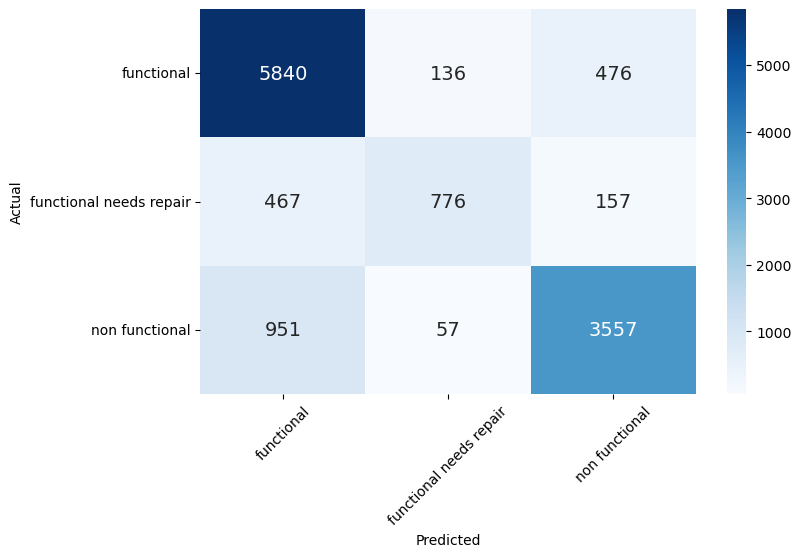

In [1541]:
# Create training and test sets: test size 0.2
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)

# vc = VotingClassifier([('rf', rf), ('xgb', xgb),('cat', cat), ('bag', bag)], voting = 'soft', weights = [0.861, 0.78, 0.706, 0.751])
vc = VotingClassifier([('rf', rf), ('xgb', xgb),('cat', cat), ('bag', bag)], voting = 'soft', weights = [0.85, 1, 0.85, 0.75])

#fit and predict
vc.fit(X_train , y_train)
pred= vc .predict(X_test)
pred_train = vc .predict(X_train)

# Calculate accuracy scores
accuracy_train = accuracy_score(y_train, pred_train)
accuracy_test = accuracy_score(y_test, pred)

# Calculate precision scores
precision_train = precision_score(y_train, pred_train, average='weighted')
precision_test = precision_score(y_test, pred, average='weighted')

# Calculate recall scores
recall_train = recall_score(y_train, pred_train, average='weighted')
recall_test = recall_score(y_test, pred, average='weighted')

# Calculate F1 scores
f1_train = f1_score(y_train, pred_train, average='weighted')
f1_test = f1_score(y_test, pred, average='weighted')

# Print the scores
print("Accuracy score (train): {:.4f}".format(accuracy_train))
print("Accuracy score (test): {:.4f}".format(accuracy_test))
print("Precision score (train): {:.4f}".format(precision_train))
print("Precision score (test): {:.4f}".format(precision_test))
print("Recall score (train): {:.4f}".format(recall_train))
print("Recall score (test): {:.4f}".format(recall_test))
print("F1 score (train): {:.4f}".format(f1_train))
print("F1 score (test): {:.4f}".format(f1_test))


#print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, pred))

#heatmap
fig, ax = plt.subplots(figsize=(8,5)) 
data = confusion_matrix(y_test, pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
ax = sns.heatmap(df_cm, cmap='Blues', fmt='g' ,annot=True,annot_kws={"size": 14})
ax.set_xlabel("Predicted")
ax.set_ylabel ("Actual")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_yticklabels(ax.get_xticklabels(), rotation=0)
plt.show()

In [1542]:
# # MAKE ENSEMBLE OF 11 XGBOOSTS

# #Create data frame to hold the 11 solutions developed by the model
# solution.table<-data.frame(id=data_test[,"id"])
# for (i in 2:12){
#   #Set seed so that the results are reproducible
#   set.seed(i)

# #Cross validation to determine the number of iterations to run the model.
# #I tested this model with a variety of parameters to find the most accurate model
# xgb.tab = xgb.cv(data = train.DMatrix, objective = "multi:softmax", booster = "gbtree",
#                  nrounds = 500, nfold = 4, early.stop.round = 10, num_class = 4, maximize = FALSE,
#                  evaluation = "merror", eta = .2, max_depth = 12, colsample_bytree = .4)

# #Create variable that identifies the optimal number of iterations for the model
# min.error.idx = which.min(xgb.tab[, test.merror.mean])

# #Create model using the same parameters used in xgb.cv
# model <- xgboost(data = train.DMatrix, objective = "multi:softmax", booster = "gbtree",
#                  eval_metric = "merror", nrounds = min.error.idx, 
#                  num_class = 4,eta = .2, max_depth = 14, colsample_bytree = .4)

# #Predict. Used the data_test.noID because it contained the same number of columns as the train.DMatrix
# #used to build the model.
# predict <- predict(model,data_test.noID)

# #Modify prediction labels to match submission format
# predict[predict==1]<-"functional"
# predict[predict==2]<-"functional needs repair"
# predict[predict==3]<-"non functional"

# #View prediction
# table(predict)

# #Add the solution to column i of the solutions data frame. This creates a data frame with a column for
# #each prediction set. Each prediction is a vote for that prediction. Next I will count the number of votes
# #for each prediction as use the element with the most votes as my final solution.
# solution.table[,i]<-predict
# }

# #Count the number of votes for each solution for each row
# solution.table.count<-apply(solution.table,MARGIN=1,table)

# #Create a vector to hold the final solution
# predict.combined<-vector()

# x=1
# #Finds the element that has the most votes for each prediction row
# for (x in 1:nrow(data_test)){
#   predict.combined[x]<-names(which.max(solution.table.count[[x]]))}

# #View the number of predictions for each classification
# table(predict.combined)

# #Create solution data frame
# solution<- data.frame(id=data_test[,"id"], status_group=predict.combined)

# #View the first five rows of the solution to ensure that it follows submission format rules
# head(solution)

In [1543]:
#fit on foll training set
vc.fit(X , y)

#predict
submission = test_set.drop(['id', 'status_group'], axis=1)
submission['status_group'] = vc.predict(submission)

#bring the id column back
submission['id'] = test_set['id']

#create df for submission and save
best_submission = submission[['id', 'status_group']]
best_submission.head()

Learning rate set to 0.097671
0:	learn: 1.0341875	total: 8.83ms	remaining: 8.82s
1:	learn: 0.9821496	total: 23.6ms	remaining: 11.8s
2:	learn: 0.9403873	total: 33.2ms	remaining: 11s
3:	learn: 0.9096258	total: 43.8ms	remaining: 10.9s
4:	learn: 0.8764796	total: 65.8ms	remaining: 13.1s
5:	learn: 0.8498704	total: 76.3ms	remaining: 12.6s
6:	learn: 0.8279151	total: 88.8ms	remaining: 12.6s
7:	learn: 0.8076205	total: 101ms	remaining: 12.5s
8:	learn: 0.7897616	total: 113ms	remaining: 12.4s
9:	learn: 0.7724728	total: 124ms	remaining: 12.2s
10:	learn: 0.7588810	total: 139ms	remaining: 12.5s
11:	learn: 0.7458494	total: 148ms	remaining: 12.2s
12:	learn: 0.7354765	total: 158ms	remaining: 12s
13:	learn: 0.7259201	total: 169ms	remaining: 11.9s
14:	learn: 0.7173226	total: 180ms	remaining: 11.8s
15:	learn: 0.7084768	total: 189ms	remaining: 11.6s
16:	learn: 0.7012022	total: 198ms	remaining: 11.4s
17:	learn: 0.6932671	total: 212ms	remaining: 11.6s
18:	learn: 0.6865166	total: 231ms	remaining: 11.9s
19:	lear

,id,status_group
62082,50785,non functional
62083,51630,functional
62084,17168,functional
62085,45559,non functional
62086,49871,functional


In [1544]:
best_submission.to_csv('best_submission.csv', index=False)